# demo: TextGraph + LLMs

## intro

In [1]:
import pathlib
from IPython.display import display, HTML, Image

display(HTML(pathlib.Path("docs/demo/blurb.1.html").read_text(encoding = "utf-8")))

## parse a document

In [2]:
from icecream import ic
import pandas as pd
import pyvis
import spacy

from textgraph import Edge, Node, Pipeline, PipelineFactory, RenderPyVis, TextGraph

this library is intented for processing a stream of paragraphs:

In [3]:
SRC_TEXT: str = """                                                                                                                      
Werner Herzog is a remarkable filmmaker and an intellectual originally from Germany, the son of Dietrich Herzog.
Although in fact Werner Herzog never really liked his father, as we all know.
After the war, Werner fled to America to become famous.
"""

In [4]:
tg: TextGraph = TextGraph()

fabrica: PipelineFactory = PipelineFactory(
    #ner_model = PipelineFactory.NER_MODEL,
)

pipe: Pipeline = fabrica.build_pipeline(
    SRC_TEXT.strip(),
)

2023-12-06 12:43:40,137 - root - INFO - Initializing word embedding with word2vec.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [5]:
spacy.displacy.render(
    pipe.ent_doc,
    style = "ent",
    jupyter = True,
)

In [6]:
spacy.displacy.render(
    pipe.ent_doc,
    style = "dep",
    jupyter = True,
)

## build a lemma graph from the document

In [7]:
tg.build_graph_embeddings(
    pipe,
    debug = False,
)

ic(len(tg.nodes.values()));

ic| len(tg.nodes.values()): 53


In [8]:
tg.calc_phrase_ranks()

ic(tg.edges);

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ic| tg.edges: {'0.1.nsubj.0': Edge(src_node=0, dst_node=1, kind=<RelEnum.DEP: 0>, rel='nsubj', prob=1.0, count=1),
               '0.19.nsubj.0': Edge(src_node=0, dst_node=19, kind=<RelEnum.DEP: 0>, rel='nsubj', prob=1.0, count=1),
               '0.50.dbpedia.4': Edge(src_node=0, dst_node=50, kind=<RelEnum.IRI: 4>, rel='dbpedia', prob=1.0, count=1),
               '10.51.dbpedia.4': Edge(src_node=10, dst_node=51, kind=<RelEnum.IRI: 4>, rel='dbpedia', prob=0.9951332880088557, count=1),
               '10.9.pobj.0': Edge(src_node=10, dst_node=9, kind=<RelEnum.DEP: 0>, rel='pobj', prob=1.0, count=1),
               '11.10.punct.0': Edge(src_node=11, dst_node=10, kind=<R

show the resulting entities extracted from the document

In [9]:
df: pd.DataFrame = tg.get_phrases_as_df()
df

,node_id,text,pos,label,count,weight
0,0,Werner Herzog,PROPN,http://dbpedia.org/resource/Werner_Herzog,2,0.067311
1,10,Germany,PROPN,http://dbpedia.org/resource/Germany,1,0.066063
2,15,Dietrich Herzog,PROPN,http://dbpedia.org/resource/Marlene_Dietrich,1,0.064957
3,20,fact,NOUN,None,1,0.062771
4,35,war,NOUN,None,1,0.062771
5,37,Werner,PROPN,dbo:Person,1,0.062771
6,40,America,PROPN,dbo:Country,1,0.062771
7,45,a remarkable filmmaker,noun_chunk,None,1,0.062771
8,4,filmmaker,NOUN,None,1,0.061693
9,46,an intellectual,noun_chunk,None,1,0.061519


## visualize the lemma graph

In [10]:
render: RenderPyVis = RenderPyVis(
    tg.nodes,
    tg.edges,
    tg.lemma_graph,
)

pv_graph: pyvis.network.Network = render.build_lemma_graph(
    debug = False,
)

set the layout parameters

In [11]:
pv_graph.force_atlas_2based(
    gravity = -38,
    central_gravity = 0.01,
    spring_length = 231,
    spring_strength = 0.7,
    damping = 0.8,
    overlap = 0,
)

pv_graph.show_buttons(filter_ = [ "physics" ])
pv_graph.toggle_physics(True)

In [12]:
pv_graph.prep_notebook()
pv_graph.show("vis.html")

vis.html


## generate a word cloud

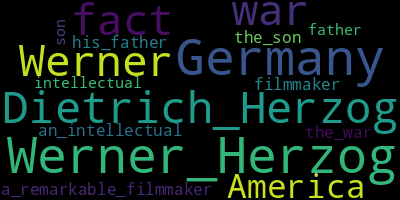

In [13]:
wordcloud = render.generate_wordcloud()
display(wordcloud.to_image())

## cluster communities in the lemma graph

In the tutorial
<a href="https://towardsdatascience.com/how-to-convert-any-text-into-a-graph-of-concepts-110844f22a1a" target="_blank">"How to Convert Any Text Into a Graph of Concepts"</a>, 
Rahul Nayak uses the
<a href="https://en.wikipedia.org/wiki/Girvan%E2%80%93Newman_algorithm"><em>girvan-newman</em></a>
algorithm to split the graph into communities, then clusters on those communities.
His approach works well for unsupervised clustering of key phrases which have been extracted from many documents.
In contrast, Nayak was working with entities extracted from "chunks" of text, not with a text graph.

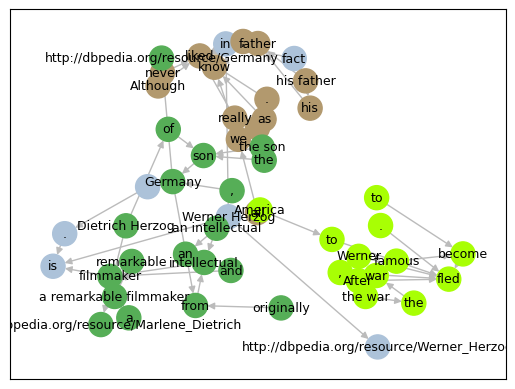

In [14]:
import matplotlib.pyplot as plt

render.draw_communities()
plt.show()

## infer relations

In [15]:
if False:
    tg.infer_relations(
        pipe,
        debug = True,
    )

## outro

_\[ more parts are in progress, getting added to this demo \]_